# Spatio-temporal buffer analysis

In [ ]:
import swisslandstats as sls
from shapely.geometry import Point

import pylandstats as pls

In order to combine the `BufferAnalysis` and `SpatioTemporalAnalysis`, PyLandStats features an additional `SpatioTemporalBufferAnalysis` analysis class.

Like in the [Spatio-temporal analysis example](https://github.com/martibosch/pylandstats-notebooks/blob/master/notebooks/02-spatiotemporal-analysis.ipynb), we will use the three extracts of [Veveyse district](https://en.wikipedia.org/wiki/Veveyse_District) from the [Swiss Land Statistics (SLS) datasets from the Swiss Federal Statistical Office](https://www.bfs.admin.ch/bfs/en/home/services/geostat/swiss-federal-statistics-geodata/land-use-cover-suitability/swiss-land-use-statistics.html) for the years 1992, 2004 and 2012, yet in this case we also need to specify how the buffers are constructed. 

We first need to run the cell below so that the land use/land cover (LULC) data is downloaded and preprocessed (see [A03-swisslandstats-preprocessing.ipynb](https://github.com/martibosch/pylandstats-notebooks/blob/master/notebooks/A03-swisslandstats-preprocessing.ipynb) for more details).

In [ ]:
!make -C .. lulc_rasters

make: Entering directory '/home/martibosch/data-science/pylandstats-notebooks'
make: Nothing to be done for 'lulc_rasters'.
make: Leaving directory '/home/martibosch/data-science/pylandstats-notebooks'


Let us now consider three buffers of 2, 4 and 6km around the town of Chatel-St-Denis:

In [ ]:
URBAN_CLASS_VAL = 1
input_filepaths = [
    "../data/processed/veveyse-AS97R_4.tif",
    "../data/processed/veveyse-AS09R_4.tif",
    "../data/processed/veveyse-AS18_4.tif",
]
years = ["1992", "2004", "2012"]

# latitude and longitude of the center of Chatel-St-Denis according to OpenStreetMap
base_mask = Point(6.8992073, 46.52634)
base_mask_crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"

# buffer distances (in meters)
buffer_dists = [2000, 4000, 6000]

stba = pls.SpatioTemporalBufferAnalysis(
    input_filepaths, base_mask, buffer_dists, base_mask_crs=base_mask_crs, dates=years
)

Analogously to `BufferAnalysis`, we could also initialize the from a polygon geometry (such an administrative boundary) by passing such object as the `base_mask` argument. See [the zonal analysis notebook](https://github.com/martibosch/pylandstats-notebooks/blob/master/notebooks/03-zonal-analysis.ipynb) to see how this can be done

Like `SpatioTemporalAnalysis`, `BufferAnalysis` and/or `ZonalAnalysis`, we can compute the data frame of class metrics through the `compute_class_metrics_df` method:

In [ ]:
class_metrics_df = stba.compute_class_metrics_df()
class_metrics_df.head()

metric                      total_area proportion_of_landscape  \
buffer_dist class_val dates                                      
2000        1         1992       205.0               17.672414   
                      2004       245.0                21.12069   
                      2012       281.0               24.224138   
            2         1992       741.0                63.87931   
                      2004       698.0               60.172414   

metric                      number_of_patches patch_density  \
buffer_dist class_val dates                                   
2000        1         1992               38.0      3.275862   
                      2004               34.0      2.931034   
                      2012               25.0      2.155172   
            2         1992                7.0      0.603448   
                      2004                7.0      0.603448   

metric                      largest_patch_index total_edge edge_density  \
buffer_dist class_val dates                                               
2000        1         1992             6.982759    45100.0     38.87931   
                      2004             8.103448    48900.0    42.155172   
                      2012            16.465517    50900.0     43.87931   
            2         1992            49.051724    71400.0    61.551724   
                      2004            46.465517    73800.0     63.62069   

metric                      landscape_shape_index effective_mesh_size  \
buffer_dist class_val dates                                             
2000        1         1992               7.896552            6.723276   
                      2004                7.78125            9.961207   
                      2012               7.647059           32.356034   
            2         1992               7.527273          300.950862   
                      2004               8.018868          259.891379   

metric                          area_mn  ... fractal_dimension_md  \
buffer_dist class_val dates              ...                        
2000        1         1992     5.394737  ...             1.005947   
                      2004     7.205882  ...             1.011893   
                      2012        11.24  ...             1.011893   
            2         1992   105.857143  ...             1.050162   
                      2004    99.714286  ...             1.107502   

metric                      fractal_dimension_ra fractal_dimension_sd  \
buffer_dist class_val dates                                             
2000        1         1992              0.184165             0.049826   
                      2004              0.178114             0.053776   
                      2012              0.220343             0.058504   
            2         1992              0.228923             0.092117   
                      2004              0.236814             0.087711   

metric                      fractal_dimension_cv  \
buffer_dist class_val dates                        
2000        1         1992              4.818704   
                      2004              5.172022   
                      2012              5.599764   
            2         1992              8.490666   
                      2004              7.929402   

metric                      euclidean_nearest_neighbor_mn  \
buffer_dist class_val dates                                 
2000        1         1992                     254.487263   
                      2004                     237.507684   
                      2012                     253.663519   
            2         1992                          200.0   
                      2004                     214.285714   

metric                      euclidean_nearest_neighbor_am  \
buffer_dist class_val dates                                 
2000        1         1992                     222.764975   
                      2004                     212.264388   
                      20

Note that in this case, the data frame features a three-level [MultiIndex](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.MultiIndex.html) that distinguishes the computed value for each buffer distances, class values, and date. Again, we can operate upon such data frames as we would do with any other pandas data frame. For instance, we might want to evaluate the difference between the area-weighted fractal dimension of urban patches (represented by a `class_val` of 1) computed at the extent of a 6km buffer and a 4km buffer:

In [ ]:
(
    class_metrics_df.loc[(6000, 1), "fractal_dimension_am"]
    - class_metrics_df.loc[(4000, 1), "fractal_dimension_am"]
)

dates
1992   -0.003925
2004   -0.007148
2012   -0.022498
Name: fractal_dimension_am, dtype: object

We can also obtain the data frame of landscape metrics can be obtained as follows:

In [ ]:
stba.compute_landscape_metrics_df()

metric             total_area  number_of_patches  patch_density  \
buffer_dist dates                                                 
2000        1992       1160.0               94.0       8.103448   
            2004       1160.0               93.0       8.017241   
            2012       1160.0               84.0       7.241379   
4000        1992       3685.0              219.0       5.943012   
            2004       3685.0              214.0       5.807327   
            2012       3685.0              199.0       5.400271   
6000        1992       7195.0              396.0       5.503822   
            2004       7195.0              385.0       5.350938   
            2012       7195.0              375.0       5.211953   

metric             largest_patch_index  total_edge  edge_density  \
buffer_dist dates                                                  
2000        1992             49.051724     79600.0     68.620690   
            2004             46.465517     83200.0     71.724138   
            2012             43.793103     84700.0     73.017241   
4000        1992             48.032564    225100.0     61.085482   
            2004             46.947083    230600.0     62.578019   
            2012             45.210312    234900.0     63.744912   
6000        1992             48.644892    428400.0     59.541348   
            2004             47.713690    432700.0     60.138985   
            2012             46.309937    437600.0     60.820014   

metric             landscape_shape_index  effective_mesh_size   entropy  \
buffer_dist dates                                                         
2000        1992                7.086957           311.250000  1.385050   
            2004                7.347826           273.368966  1.457972   
            2012                7.456522           264.284483  1.491411   
4000        1992               10.815574           973.771777  1.344319   
            2004               11.040984           890.491452  1.391068   
            2012               11.217213           836.093080  1.427391   
6000        1992               14.470588          2051.480890  1.335630   
            2004               14.597059          1976.238360  1.368637   
            2012               14.741176          1880.441835  1.401519   

metric             shannon_diversity_index  ...  fractal_dimension_md  \
buffer_dist dates                           ...                         
2000        1992                  0.960043  ...              1.005947   
            2004                  1.010589  ...              1.011893   
            2012                  1.033768  ...              1.011893   
4000        1992                  0.931811  ...              1.000000   
            2004                  0.964215  ...              1.000000   
            2012                  0.989392  ...              1.011893   
6000        1992                  0.925788  ...              1.000000   
            2004                  0.948667  ...              1.000000   
            2012                  0.971459  ...              1.000000   

metric             fractal_dimension_ra  fractal_dimension_sd  \
buffer_dist dates                                               
2000        1992               0.228923              0.052346   
            2004               0.236814              0.054679   
            2012               0.240666              0.056555   
4000        1992               0.264684              0.052244   
            2004               0.270727              0.054087   
            2012               0.273152              0.056090   
6000        1992               0.292576              0.050082   
            2004               0.295313              0.050986   
            2012               0.297394              0.051537   

metric             fractal_dimension_cv  euclidean_nearest_neighbor_mn  \
buffer_dist dates                                                        
2000        1992   

Likewise in the other classes of PyLandStats, if we want to compute the metrics data frame only for a subset of metrics or classes, or customize how the metrics are computed, we must respectively pass the arguments `metrics`, `classes` or `metrics_kws` to the `compute_class_metrics_df` and `compute_landscape_metrics_df` methods of `SpatioTemporalBufferAnalysis` as in:

In [ ]:
metrics = ["proportion_of_landscape", "edge_density", "fractal_dimension_am"]
classes = [URBAN_CLASS_VAL]
metrics_kws = {
    "proportion_of_landscape": {"percent": False},
    "edge_density": {"count_boundary": True},
}
stba.compute_class_metrics_df(metrics=metrics, classes=classes, metrics_kws=metrics_kws)

metric                      proportion_of_landscape edge_density  \
buffer_dist class_val dates                                        
2000        1         1992                 0.176724    39.482759   
                      2004                 0.211207    42.931034   
                      2012                 0.242241    44.827586   
4000        1         1992                  0.09118    23.880597   
                      2004                 0.109091    25.888738   
                      2012                 0.127273    27.516961   
6000        1         1992                  0.08214      21.9041   
                      2004                 0.094788    22.932592   
                      2012                 0.109104    24.100069   

metric                      fractal_dimension_am  
buffer_dist class_val dates                       
2000        1         1992              1.120612  
                      2004              1.129215  
                      2012              1.180027  
4000        1         1992              1.098595  
                      2004              1.107694  
                      2012              1.148513  
6000        1         1992               1.09467  
                      2004              1.100546  
                      2012              1.126015

## Plots

Perhaps the most important functionality of the `SpatioTemporalBufferAnalysis` is plotting the time series of metrics at each spatial extent. We can accomplish that through the `plot_metric` method. For instance, let us plot the proportion of landscape at the level of the *urban* class (`class_val` of 1):

<Axes: ylabel='PLAND'>

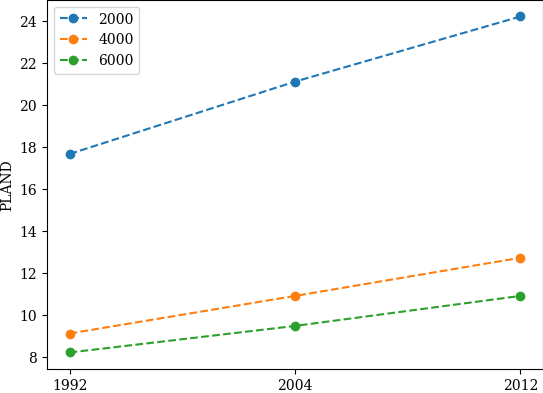

In [ ]:
stba.plot_metric("proportion_of_landscape", class_val=URBAN_CLASS_VAL)

Similarly, we can produce the same plot at the landscape level by ommiting the `class_val` argument:

<Axes: ylabel='FRAC_AM'>

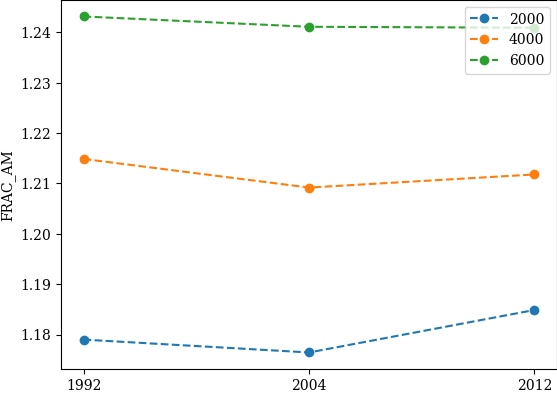

In [ ]:
stba.plot_metric("fractal_dimension_am")

On the other hand, we might use the `plot_landscapes` method to plot the considered landscapes for each buffer distance (row) and year (column):

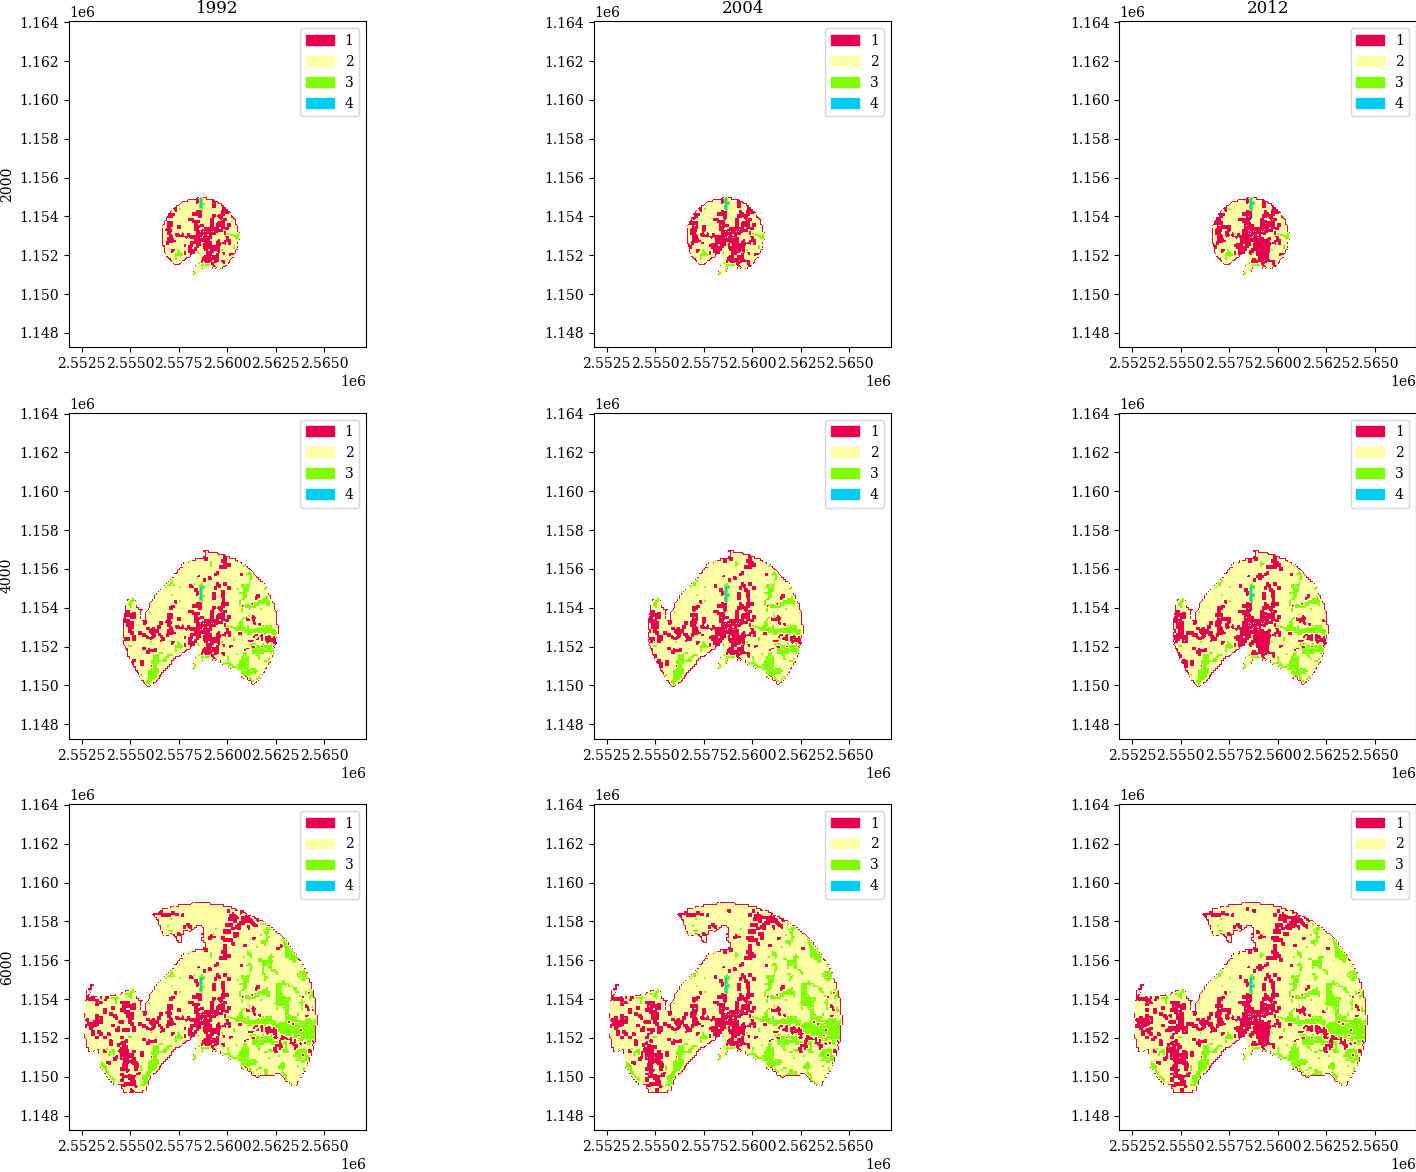

In [ ]:
fig = stba.plot_landscapes(
    cmap=sls.noas04_4_cmap, show_kws=dict(norm=sls.noas04_4_norm)
)